# Visualize metapath performance against permutation

In [1]:
library(dplyr, warn = FALSE)

In [2]:
auroc_df = readr::read_tsv('data/auroc.tsv') %>%
  dplyr::mutate(fdr_significant = fdr_pval_auroc <= 0.05) %>%
  dplyr::filter(feature_type == 'DWPC') %>%
  dplyr::rename(metapath = feature)
head(auroc_df, 2)

,feature_type,metapath,nonzero,auroc,auroc_permuted,delta_auroc,pval_auroc,fdr_pval_auroc,fdr_significant
1,DWPC,CbG<rG<rGaD,0.84185,0.64161,0.5749,0.066707,6.3953e-05,0.001563,TRUE
2,DWPC,CbG<rG<rGdD,0.37907,0.58289,0.55856,0.024336,0.00025452,0.0030794,TRUE


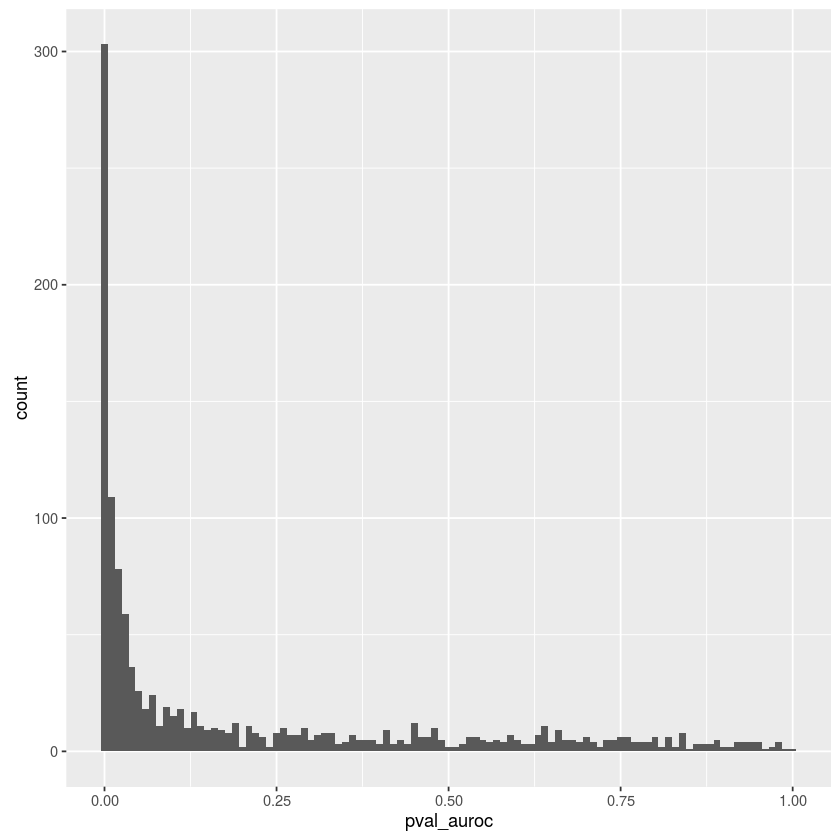

In [3]:
auroc_df %>%
  ggplot2::ggplot(ggplot2::aes(x = pval_auroc)) +
  ggplot2::geom_histogram(binwidth = 0.01)

In [4]:
# metapath_df = 'data/metapaths.tsv' %>%
#   readr::read_tsv()  %>%
#   dplyr::transmute(metapath = abbreviation, length)

metaedge_df = readr::read_tsv('data/metaedge-in-metapath.tsv') %>%
  dplyr::inner_join(auroc_df)

head(metaedge_df, 2)

Joining by: "metapath"


,metapath,metaedge,metaedge_abbrev,position,length,feature_type,nonzero,auroc,auroc_permuted,delta_auroc,pval_auroc,fdr_pval_auroc,fdr_significant
1,CbGaD,Compound - binds - Gene,CbG,1,2,DWPC,0.31444,0.71627,0.57794,0.13832,2.9403e-06,0.00025664,TRUE
2,CbGaD,Disease - associates - Gene,DaG,2,2,DWPC,0.31444,0.71627,0.57794,0.13832,2.9403e-06,0.00025664,TRUE


In [5]:
metaedge_summary_df = metaedge_df %>%
  dplyr::group_by(metaedge) %>%
  dplyr::summarize(
    max_auroc = max(auroc),
    max_delta_auroc = max(delta_auroc)
  ) %>%
  dplyr::arrange(max_delta_auroc)

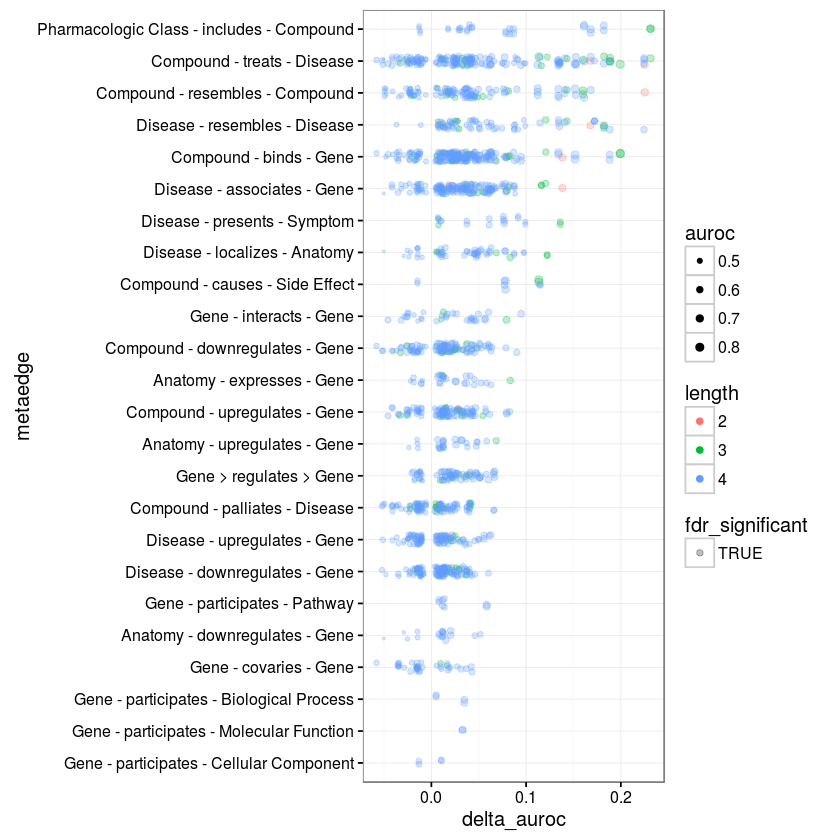

In [6]:
metaedge_df %>%
  dplyr::filter(fdr_significant) %>%
  dplyr::mutate(length = as.character(length)) %>%
  ggplot2::ggplot(mapping = ggplot2::aes(x = delta_auroc, y = metaedge)) +
  ggplot2::geom_jitter(mapping = ggplot2::aes(alpha = fdr_significant, color = length, size=auroc), height=0.4) +
  ggplot2::scale_y_discrete(limits = metaedge_summary_df$metaedge) +
  ggplot2::scale_alpha_manual(values=c('TRUE' = 0.25, 'FALSE' = 0.05)) +
  ggplot2::scale_size_continuous(range = c(0.5, 2)) +
  ggplot2::theme_bw()

In [7]:
mean(p.adjust(p = auroc_df$pval_auroc, method = 'bonferroni') < 0.05)

[1] 0.03233831

In [8]:
mean(auroc_df$fdr_pval_auroc < 0.05)

[1] 0.3689884

In [9]:
mean(auroc_df$pval_auroc < 0.05)

[1] 0.4975124